Final altitude: 0.9999986645777819
Final velocities: [ 0.00000000e+00  0.00000000e+00 -3.40210104e-07]


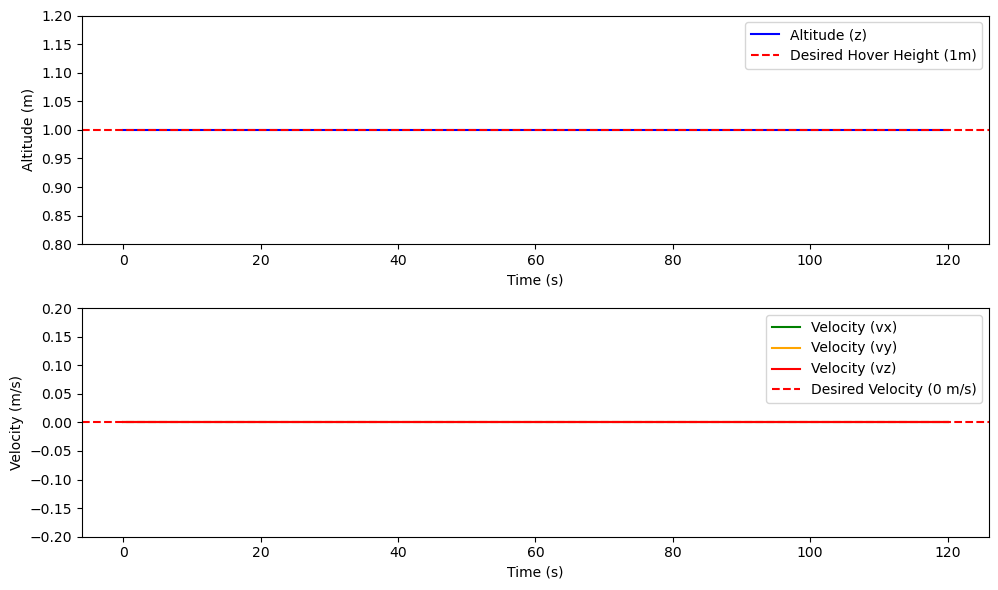

Required motor speed (for each motor) to maintain hover: 7872.60 rad/s


In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants (adjust these as needed)
m = 0.652  # mass of the quadcopter (kg)
g = 9.81  # gravitational acceleration (m/s^2)
Ixx = 4.856 * 1e-2  # Moment of inertia around x-axis (kg*m^2)
Iyy = 4.856 * 1e-2  # Moment of inertia around y-axis (kg*m^2)
Izz = 8.801 * 1e-2  # Moment of inertia around z-axis (kg*m^2)
K = 2.58 * 1e-8  # thrust coefficient (N per motor speed squared)
l = 0.1225  # arm length (m)
b = 1.14 * 1e-7  # drag coefficient
A_x = 0.25  # drag coefficient along x-axis
A_y = 0.25  # drag coefficient along y-axis
A_z = 0.25  # drag coefficient along z-axis

# Control inputs (motor speeds, initially equal for all motors in hover)
def calculate_hover_omega(mass, g, K):
    # Total thrust required to counteract gravity
    required_thrust = mass * g
    # The thrust generated by each motor is proportional to the square of its speed
    omega_hover = np.sqrt(required_thrust / (4 * K))
    return omega_hover

# PID Controller parameters (Reduced for stability)
Kp = 0.5  # Proportional gain (lowered for stability)
Ki = 0.05  # Integral gain (lowered for stability)
Kd = 0.2  # Derivative gain (lowered for stability)

# Initial conditions for PID control
integral = 0
previous_error = 0

# Calculate the motor speed required for hover
omega_hover = calculate_hover_omega(m, g, K)
omega1 = omega2 = omega3 = omega4 = omega_hover  # Set all motor speeds for hover

# Define the system of differential equations with PID control for altitude
def eom(t, state, params):
    global integral, previous_error
    
    # Unpack the state variables
    x, y, z, vx, vy, vz, phi, theta, psi, phidot, thetadot, psidot = state
    
    # Unpack parameters
    m, Ixx, Iyy, Izz, K, l, b, A_x, A_y, A_z, omega1, omega2, omega3, omega4, g = params
    
    # PID Control for altitude (z)
    desired_altitude = 1.0  # Target altitude (1 meter)
    altitude_error = desired_altitude - z  # Error in altitude
    integral += altitude_error  # Integrate error for the integral term
    derivative = altitude_error - previous_error  # Derivative of the error
    previous_error = altitude_error  # Update previous error
    
    # PID Control output for motor speed adjustment
    control_signal = Kp * altitude_error + Ki * integral + Kd * derivative
    
    # Adjust motor speeds based on PID control (add or subtract from hover speed)
    omega1 = omega_hover + control_signal
    omega2 = omega_hover + control_signal
    omega3 = omega_hover + control_signal
    omega4 = omega_hover + control_signal
    
    # Limit motor speeds to reasonable values to prevent excessive thrust
    omega1 = np.clip(omega1, omega_hover - 1, omega_hover + 1)
    omega2 = np.clip(omega2, omega_hover - 1, omega_hover + 1)
    omega3 = np.clip(omega3, omega_hover - 1, omega_hover + 1)
    omega4 = np.clip(omega4, omega_hover - 1, omega_hover + 1)
    
    # Total thrust term (sum of squared angular velocities)
    total_thrust = omega1**2 + omega2**2 + omega3**2 + omega4**2
    
    # Translational accelerations
    ax = A_x * vx - K * (np.sin(phi) * np.sin(psi) + np.sin(theta) * np.cos(phi) * np.cos(psi)) * total_thrust
    ay = A_y * vy - K * (-np.sin(phi) * np.cos(psi) + np.sin(psi) * np.sin(theta) * np.cos(phi)) * total_thrust
    az = A_z * vz - K * np.cos(phi) * np.cos(theta) * total_thrust + m * g
    
    # Rotational accelerations
    phiddot = (-Ixx * phidot * np.sin(theta) - Ixx * psidot * np.dot(np.sin(theta), np.cos(theta)) 
               - 0.5 * Iyy * psidot * np.sin(phi) * np.cos(theta) + K * l * (-omega2**2 + omega4**2))
    
    thetaddot = (Ixx * psidot * (phidot - psidot * np.sin(theta)) * np.cos(theta) + Iyy * psidot 
                 * (phidot * np.sin(theta) + thetadot * np.cos(theta)) + Izz * psidot 
                 * (phidot * np.cos(theta) - thetadot * np.sin(theta)) + K * l * (-omega1**2 + omega3**2))
    
    psiddot = 0  # Assuming no angular acceleration around psi
    
    # Return the derivatives of the state variables
    return [
        vx,  # dx/dt
        vy,  # dy/dt
        vz,  # dz/dt
        ax,  # dvx/dt
        ay,  # dvy/dt
        az,  # dvz/dt
        phidot,  # dphi/dt
        thetadot,  # dtheta/dt
        psidot,  # dpsi/dt
        phiddot,  # dphidot/dt
        thetaddot,  # dthetadot/dt
        psiddot   # dpsidot/dt
    ]

# Initial conditions for hover (position at 1m, no initial velocity, no initial rotation)
initial_conditions = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Parameters for the system
params = [m, Ixx, Iyy, Izz, K, l, b, A_x, A_y, A_z, omega1, omega2, omega3, omega4, g]

# Time span for the simulation (2 minutes for hover)
t_span = (0, 120)  # 2 minutes in seconds
t_eval = np.linspace(0, 120, 1000)  # Evaluate the solution at 1000 points

# Solve the ODE for hover
sol = solve_ivp(eom, t_span, initial_conditions, args=(params,), t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Debugging: Check for unexpected values in the solution
print("Final altitude:", sol.y[2, -1])  # Print final altitude
print("Final velocities:", sol.y[3:6, -1])  # Print final velocities

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the altitude (z) over time
plt.subplot(2, 1, 1)
plt.plot(sol.t, sol.y[2], label="Altitude (z)", color="blue")
plt.axhline(y=1.0, color='r', linestyle='--', label="Desired Hover Height (1m)")
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.ylim([0.8, 1.2])  # Set y-axis limits around the hover height

# Plot the velocities (vx, vy, vz) over time
plt.subplot(2, 1, 2)
plt.plot(sol.t, sol.y[3], label="Velocity (vx)", color="green")
plt.plot(sol.t, sol.y[4], label="Velocity (vy)", color="orange")
plt.plot(sol.t, sol.y[5], label="Velocity (vz)", color="red")
plt.axhline(y=0.0, color='r', linestyle='--', label="Desired Velocity (0 m/s)")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.ylim([-0.2, 0.2])  # Set y-axis limits to visualize small velocity variations

plt.tight_layout()
plt.show()

# Print out the required motor speeds to maintain hover
print(f"Required motor speed (for each motor) to maintain hover: {omega_hover:.2f} rad/s")